## **A/B Testing Case**<br>
#### Dataset from [Kaggle](https://www.kaggle.com/datasets/zhangluyuan/ab-testing)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data from drive

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data DS Bootcamp/ab_data.csv')
# Check information
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


### Data Cleaning

In [ ]:
# Check missing values
df.isna().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [ ]:
# Check Duplicate
df.duplicated().sum()

np.int64(0)

In [ ]:
# Check if there are multiple input by the same user id
df['user_id'].duplicated().sum()

np.int64(3894)

In [ ]:
df[df['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


*There are some users that filled out more than once, possibly filling both control and treatment group*

In [ ]:
# Copy dataframe before cleaning
df_clean = df.copy()
# Delete duplicate user_id, keeping the first occurence
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')

In [ ]:
df_clean['user_id'].duplicated().sum()

np.int64(0)

In [ ]:
df_clean

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [ ]:
# Check the consistency between 'group' and 'landing_page'
# Select rows where the user in 'treatment' but did not in 'new_page', and vice-versa
mismatch = df_clean[
    ((df_clean['group'] == 'treatment') & (df_clean['landing_page'] != 'new_page')) |
    ((df_clean['group'] == 'control') & (df_clean['landing_page'] != 'old_page'))
    ]
mismatch_count = mismatch.shape[0]
mismatch_count

2044

In [ ]:
# Delete the mismatched/inconsistent rows
df_clean_consistent = df_clean.drop(mismatch.index)
df_clean_consistent.shape

(288540, 5)

*Data is clean, unique, and consistent*

### Exploratory Data Analysis

In [ ]:
# Check group distribution, balanced or not
df_clean_consistent['group'].value_counts()

,count
group,
treatment,144314
control,144226


In [ ]:
df_clean_consistent['landing_page'].value_counts()

,count
landing_page,
new_page,144314
old_page,144226


*Data is balanced for both group*

In [ ]:
# Calculate conversion rate by group
group_conversion_rate = df_clean_consistent.groupby('group')['converted'].mean()
group_conversion_rate

,converted
group,
control,0.120290
treatment,0.118727


In [ ]:
# Calculate conversion rate by landing page
landing_page_conversion_rate = df_clean_consistent.groupby('landing_page')['converted'].mean()
landing_page_conversion_rate

,converted
landing_page,
new_page,0.118727
old_page,0.120290


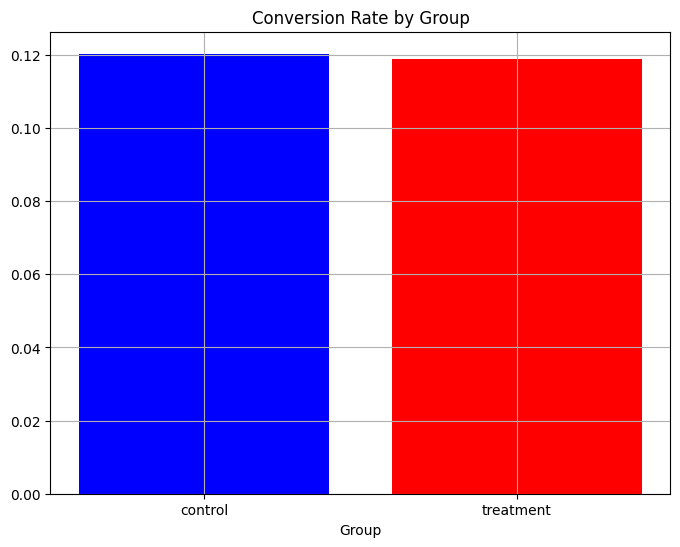

In [ ]:
# Graph to compare conversion rate by group
plt.figure(figsize=(8, 6))
plt.bar(group_conversion_rate.index, group_conversion_rate.values, color=['blue', 'red'])
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.grid(True)

*User prefer old page/control, because the conversion rate is slightly higher (12.03%) than the new page/treatment (11.87%)*

In [ ]:
# Calculate overall conversion rate
overall_conversion_rate = df_clean_consistent['converted'].mean()
overall_conversion_rate

np.float64(0.11950856033825466)

In [ ]:
# Calculate the conversion rate by time (date)

# Convert to datetime
df_clean_consistent['timestamp'] = pd.to_datetime(df_clean_consistent['timestamp'])
# Extract to new column 'date'
df_clean_consistent['date'] = df_clean_consistent['timestamp'].dt.date
# Calculate conversion rate by date
date_conversion_rate = df_clean_consistent.groupby('date')['converted'].mean()
date_conversion_rate

,converted
date,
2017-01-02,0.122373
2017-01-03,0.113772
2017-01-04,0.119232
2017-01-05,0.118844
2017-01-06,0.119297
2017-01-07,0.118563
2017-01-08,0.119913
2017-01-09,0.118712
2017-01-10,0.119958


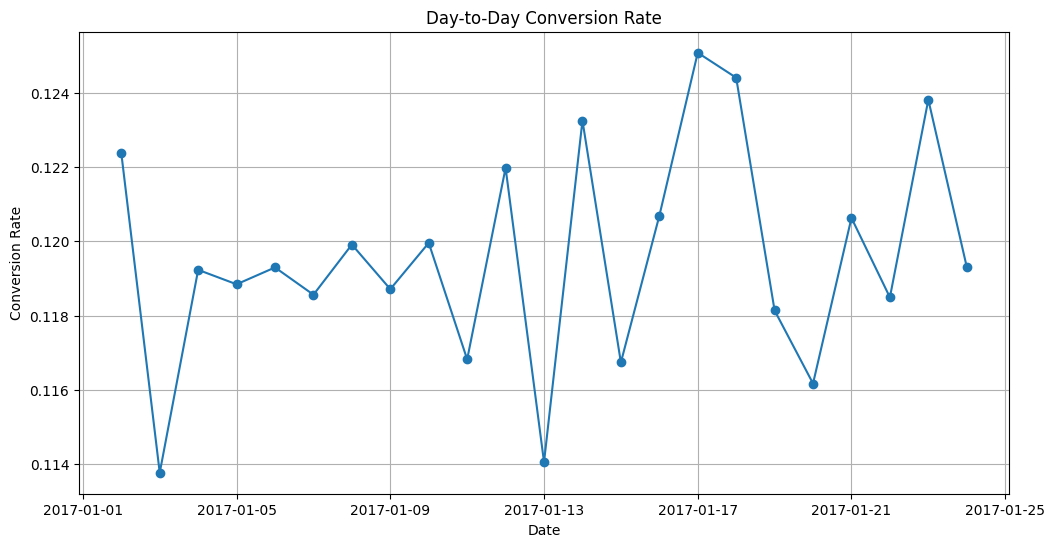

In [ ]:
# Graph for day-to-day conversion rate
# Include trendline
plt.figure(figsize=(12, 6))
plt.plot(date_conversion_rate.index, date_conversion_rate.values, marker='o')
plt.title('Day-to-Day Conversion Rate')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.grid(True)

*Based on comparation of the overall conversion rate and the day-to-day conversion rate, it is quite stable (small fluctuations)*

### Statistical Test
See wether the 0.16% difference is statistically significant

**Hypothesis**<br>
H0 = No difference in conversion rate<br>
H1 = There are difference in conversion rate

*Use Z-Test for two-tailed test*

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Splits into control and treatment
group_summary = df_clean_consistent.groupby('group')['converted'].agg(['sum', 'count'])
print(group_summary)
# Extract values
conversions = group_summary['sum'].values
n_obs = group_summary['count'].values


             sum   count
group                   
control    17349  144226
treatment  17134  144314


In [ ]:
print("Conversions:", conversions)
print("Number of Observations:", n_obs)

Conversions: [17349 17134]
Number of Observations: [144226 144314]


In [ ]:
# Two-proportion Z-Test
z_stat, p_value = proportions_ztest(count=conversions, nobs=n_obs, alternative='two-sided')
print("Z-Statistic:", z_stat)
print("P-Value:", p_value)

Z-Statistic: 1.2942367891190543
P-Value: 0.19558364287881436


In [ ]:
alpha = 0.05

# Compare with alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in conversion rates.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in conversion rates.")

Fail to reject the null hypothesis. There is no significant difference in conversion rates.


### Conclusion
There are no significant difference in conversion rate<br>
Because we failed to reject the null hypothesis